In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    FOLDERNAME = "Work/Assignment1"

    work_dir = f'/content/drive/My Drive/{FOLDERNAME}'
except ImportError:
    work_dir = './'

import sys
sys.path.append(work_dir)

import os
data_dir = os.path.join(work_dir, 'data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(work_dir)
print(data_dir)

/content/drive/My Drive/Work/Assignment1
/content/drive/My Drive/Work/Assignment1/data


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the Instructions.docx.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transferring the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code. Through this first exercise you will also learn and practice basic PyTorch tensor operations.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
import torchvision
import torchvision.transforms as transforms

# Download and construct the CIFAR-10 dataset.
train_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

print(f'CIFAR-10 training dataset has {len(train_dataset)} images, and test dataset has {len(test_dataset)} images.')

100%|██████████| 170M/170M [00:02<00:00, 73.0MB/s]


Extracting /content/drive/My Drive/Work/Assignment1/data/cifar-10-python.tar.gz to /content/drive/My Drive/Work/Assignment1/data
Files already downloaded and verified
CIFAR-10 training dataset has 50000 images, and test dataset has 10000 images.


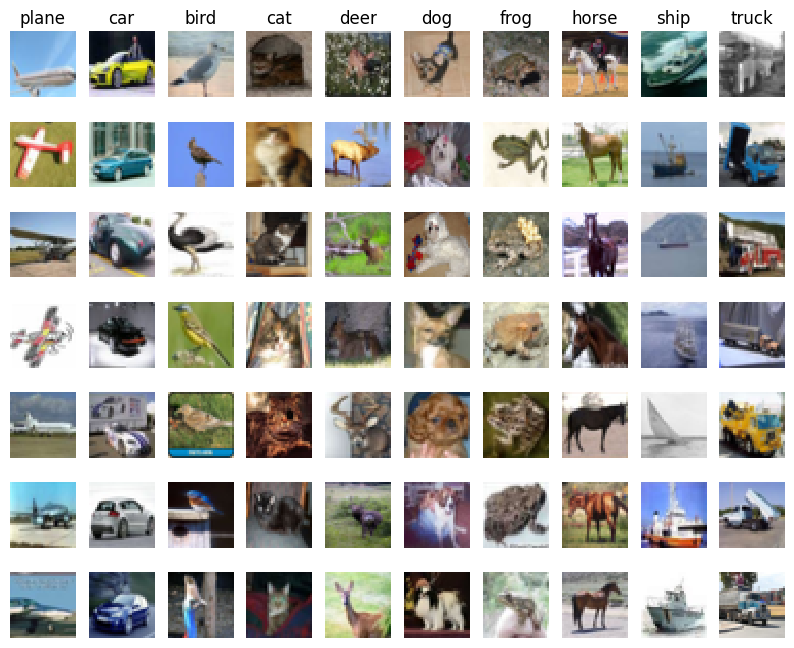

In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
y_train = np.array(train_dataset.targets)

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_dataset.data[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [12]:
num_training = 5000
train_dataset.data = train_dataset.data[:num_training]
train_dataset.targets = train_dataset.targets[:num_training]

num_test = 500
test_dataset.data = test_dataset.data[:num_test]
test_dataset.targets = test_dataset.targets[:num_test]


In [14]:
from src.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(train_dataset)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the torch.norm or np.linalg.norm() function that PyTroch or numpy provides, because this is for your own practice.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [15]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(test_dataset)
print(dists.shape)

torch.Size([500, 5000])


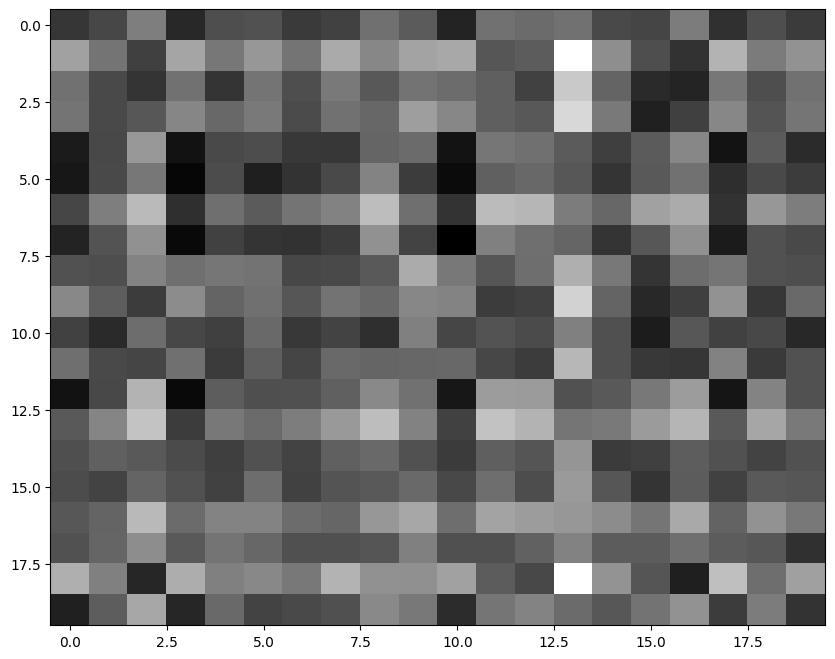

In [25]:
num_test_samples = min(20, dists.shape[0])
num_train_samples = min(20, dists.shape[1])

dists_subset = dists[:num_test_samples, :num_train_samples]
plt.imshow(dists_subset, aspect='auto', cmap='gray')

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *A row is bright if that test image is, on average, far from all training images (e.g., an outlier or underrepresented class).*

Similarly,

*A column is bright if that training image is, on average, far from all test images (e.g., a unique/outlier training sample).*


In [23]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
import torch
y_test = torch.tensor(test_dataset.targets)
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [26]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [27]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(test_dataset)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = torch.norm(dists - dists_one, p='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [28]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(test_dataset)

# check that the distance matrix agrees with the one we computed before:
difference = torch.norm(dists - dists_two, p='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.007394
Uh-oh! The distance matrices are different


In [29]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, test_dataset)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, test_dataset)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, test_dataset)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 83.656671 seconds
One loop version took 54.589046 seconds
No loop version took 0.371979 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [36]:
X_train = np.array(train_dataset.data)

In [37]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Assume X_train and y_train are already defined as numpy arrays.
X_train_folds = []
y_train_folds = []
################################################################################
# TODO:
# Split up the training data into folds. After splitting, X_train_folds and
# y_train_folds should each be lists of length num_folds, where
# y_train_folds[i] is the label vector for the points in X_train_folds[i].
# Hint: Look up the numpy array_split function.
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
k_to_accuracies = {k: np.zeros(num_folds) for k in k_choices}


################################################################################
# TODO:
# Perform k-fold cross validation to find the best value of k. For each
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,
# where in each case you use all but one of the folds as training data and the
# last fold as a validation set. Store the accuracies for all fold and all
# values of k in the k_to_accuracies dictionary.
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for fold in range(num_folds):
    X_val = X_train_folds[fold]
    y_val = y_train_folds[fold]

    X_train_cv = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != fold], axis=0)
    y_train_cv = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != fold], axis=0)

    train_dataset_cv = [(torch.tensor(x), int(y)) for x, y in zip(X_train_cv, y_train_cv)]
    val_dataset = [(torch.tensor(x), int(y)) for x, y in zip(X_val, y_val)]

    for k in k_choices:
        classifier = KNearestNeighbor()
        classifier.train(train_dataset_cv)
        # Use a vectorized implementation for efficiency
        y_val_pred = classifier.predict(val_dataset, k=k, num_loops=0)
        # Compute accuracy: number of correct predictions / total examples
        accuracy = (y_val_pred.numpy() == np.array(y_val)).mean()
        k_to_accuracies[k][fold] = accuracy
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.099000
k = 1, accuracy = 0.104000
k = 1, accuracy = 0.097000
k = 1, accuracy = 0.098000
k = 1, accuracy = 0.099000
k = 3, accuracy = 0.099000
k = 3, accuracy = 0.104000
k = 3, accuracy = 0.097000
k = 3, accuracy = 0.098000
k = 3, accuracy = 0.099000
k = 5, accuracy = 0.102000
k = 5, accuracy = 0.101000
k = 5, accuracy = 0.097000
k = 5, accuracy = 0.091000
k = 5, accuracy = 0.099000
k = 8, accuracy = 0.102000
k = 8, accuracy = 0.100000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.099000
k = 10, accuracy = 0.102000
k = 10, accuracy = 0.100000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.099000
k = 12, accuracy = 0.102000
k = 12, accuracy = 0.100000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.099000
k = 15, accuracy = 0.099000
k = 15, accuracy = 0.100000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.099000
k = 20, accuracy = 0.102000
k = 20, accu

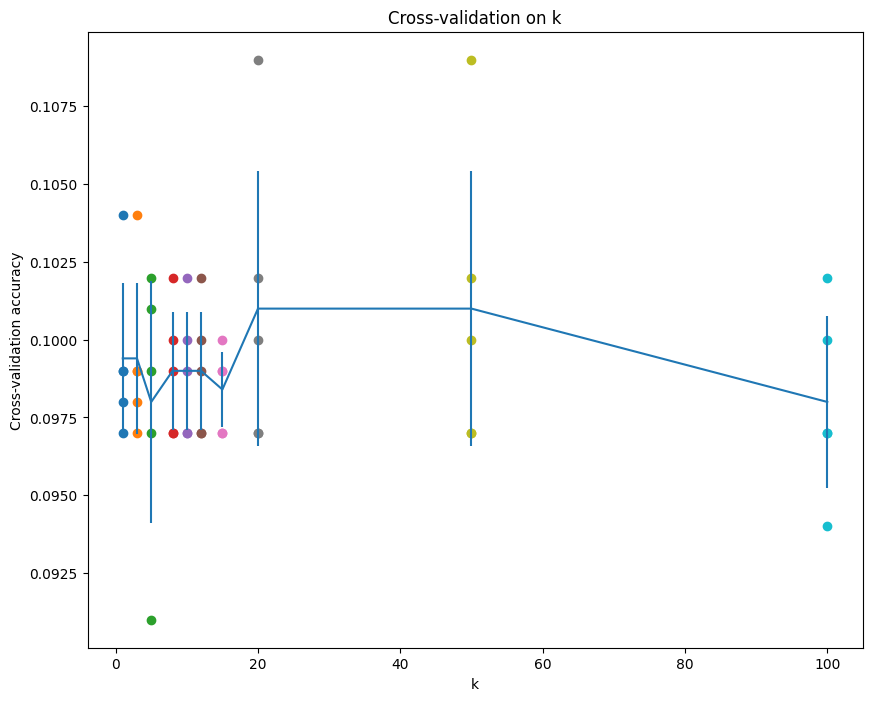

In [38]:

for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [44]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 20

classifier = KNearestNeighbor()
classifier.train(train_dataset)
y_test_pred = classifier.predict(test_dataset, k=best_k)

# Compute and display the accuracy
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 136 / 500 correct => accuracy: 0.272000


**Inline Question 2**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$ Satements 2 and 4 are correct


$\color{blue}{\textit Your Explanation:}$

Statement 2: In training (especially with leave-one-out considerations), 1-NN typically makes fewer errors than 5-NN because using more neighbors can introduce incorrect labels from nearby, but different, classes.

Statement 4: Classifying a test example requires comparing it to every training example, so the computation grows linearly with the size of the training set.

